# Fine-Tuning VGG19 using PyTorch

In the assignment, the pretrained VGG-19 convolutional neural network (CNN) will be fine-tuned on the Flower Species Dataset which includes 15 distinct flower species. Throughout the 20 experiments, alterations will be made to the model's hyperparameters, with a particular focus on observing the impact on performance.

In [8]:
# Import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### Helper Functions

In [2]:
def load_data(folder_path, batch_size):
    """
    Load data from folder path and return train, test and validation dataloaders

    :param folder_path: path to folder containing train, test and validation folders
    :param batch_size: batch size for dataloaders
    :return: train, test and validation dataloaders"""

    # Define data transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    # Load datasets
    train_dataset = datasets.ImageFolder(root=f'{folder_path}/train', transform=transform)
    val_dataset = datasets.ImageFolder(root=f'{folder_path}/val', transform=transform)
    test_dataset = datasets.ImageFolder(root=f'{folder_path}/test', transform=transform)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, val_loader

In [ ]:
def plot_losses_and_accuracies(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Plots 2 graphs side by side for the training and validation losses and accuracies .

    :param train_losses: list of training losses
    :param val_losses: list of validation losses
    :param train_accuracies: list of training accuracies
    :param val_accuracies: list of validation accuracies"""

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # Prepare x-axis data
    epochs = np.arange(1, len(train_losses)+1)

    # Plot Training and Validation Losses
    axes[0].plot(epochs, train_losses, label='Training Loss')
    axes[0].plot(epochs, val_losses, label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].set_title('Training and Validation Losses')

    # Plot Training and Validation Accuracies
    axes[1].plot(epochs, train_accuracies, label='Training Accuracy')
    axes[1].plot(epochs, val_accuracies, label='Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].set_title('Training and Validation Accuracies')

    # Show the plots
    plt.tight_layout()
    plt.show()

In [ ]:
def finetune_model(name, model, num_epochs, learning_rate, which_layers, train_loader, val_loader, device):
    """
    Finetunes the given model on the given dataset.
    Prints the training and validation losses and accuracies after each epoch.
    Plots the training and validation losses and accuracies after the training.
    Saves the finetuned model in the current folder.

    :param name: The name of the model/experiment
    :param model: The pytorch model to finetune
    :param num_epochs: The number of epochs to train the model
    :param learning_rate: The learning rate to use for finetuning
    :param which_layers: Which layers to finetune. Either 'fc1_and_fc2' or 'all_layers'
    :param train_loader: Th pytorch DataLoader for the training set
    :param val_loader: The pytorch DataLoader for the validation set
    :param device: The pytorch device to use for training
    """

    # Get the number of classes in the dataset
    num_classes = np.unique(train_loader.dataset.targets).size

    # Check which layers to fine-tune
    if which_layers == 'fc1_and_fc2':
        # Freeze convolutional layers
        for param in model.features.parameters():
            param.requires_grad = False
    elif which_layers == 'all_layers':
        pass
    else:
        raise ValueError('which_layers must be either fc1_and_fc2 or all_layers')

    # Modify the classification head
    model.classifier[-1] = nn.Linear(in_features=model.classifier[-1].in_features, out_features=num_classes)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to store training and validation losses
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    # Variables to keep track of the process
    best_val_loss = float('inf')
    epochs_wo_improvement = 0

    # Move the model to the GPU
    model.to(device)

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        total_correct_train, total_samples_train = 0, 0
        train_loss = 0.0
        for inputs, labels in train_loader:
            # Move inputs and labels to the GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # Training step
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Update training accuracy counts
            _, predicted_train = torch.max(outputs, 1)
            total_samples_train += labels.size(0)
            total_correct_train += (predicted_train == labels).sum().item()

            # Accumulate the train loss
            train_loss += loss.item() * inputs.size(0)

        # Calculate the training accuracy
        train_accuracy = total_correct_train / total_samples_train
        train_accuracies.append(train_accuracy)

        # Calculate the average train loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validate the model after each epoch
        model.eval()
        total_correct_val, total_samples_val = 0, 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move inputs and labels to the GPU
                inputs, labels = inputs.to(device), labels.to(device)

                # Get model outputs
                outputs = model(inputs)

                # Update validation accuracy counts
                _, predicted = torch.max(outputs, 1)
                total_samples_val += labels.size(0)
                total_correct_val += (predicted == labels).sum().item()

                # Accumulate the validation loss
                val_loss += criterion(outputs, labels).item() * labels.size(0)

        # Calculate the validation accuracy
        val_accuracy = total_correct_val / total_samples_val
        val_accuracies.append(val_accuracy)

        # Calculate the average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Print loss and accuracy values after each epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss}, Validation Loss: {val_loss}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_wo_improvement = 0
        else:
            epochs_wo_improvement += 1

        # Stop training if the model does not improve for 3 consecutive epochs
        if epochs_wo_improvement >= 3:
            print(f'Early stopping after {epoch+1} epochs. The model did not improve for 3 consecutive epochs.')
            break

    # Plot the losses and accuracies
    plot_losses_and_accuracies(train_losses, val_losses, train_accuracies, val_accuracies)

    # Save the state of the fine-tuned model in the current folder
    torch.save(model.state_dict(), f'finetuned_{model.__class__.__name__}_{which_layers}_{name}.pth')

In [ ]:
def evaluate_model(model, test_loader, device):
    """
    Evaluates the model on the given test set and prints confusion matrix and metrics such as, accuracy, precision, recall and F1 score.
    Returns a dict with the metrics (accuracy, precision, recall and F1 score).

    :param model: The model to evaluate
    :param test_loader: The pytorch DataLoader object that contains the test set
    :param device: The pytorch device to use for evaluation
    :return: A dict with the metrics (accuracy, precision, recall and F1 score)."""

    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move inputs and labels to the GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # Get model outputs
            outputs = model(inputs)

            # Get predictions
            _, predicted = torch.max(outputs, 1)

            # Store predictions and true labels
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Visualize the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(all_labels, all_predictions), annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Create a dict with metrics
    metrics = {
        "Accuracy": accuracy_score(all_labels, all_predictions),
        "Precision": precision_score(all_labels, all_predictions, average='macro', zero_division=0),
        "Recall": recall_score(all_labels, all_predictions, average='macro', zero_division=0),
        "F1 Score": f1_score(all_labels, all_predictions, average='macro', zero_division=0)
    }

    # Print metrics
    print(f"Accuracy: {metrics['Accuracy']}")
    print(f"Precision: {metrics['Precision']}")
    print(f"Recall: {metrics['Recall']}")
    print(f"F1 Score: {metrics['F1 Score']}")

    return metrics

In [ ]:
def finetune_and_evaluate_model(model, which_layers, num_epochs, learning_rate, batch_size, experiment_name, dataset_path, device):
    """
    Finetunes the model and evaluates it.
    Prints the training and validation losses and accuracies after each epoch at the finetuning step.
    Plots training and validation losses and accuracies at the finetuning step.
    Prints the confusion matrix and metrics such as, accuracy, precision, recall and F1 score at the evaluation step.
    Returns a dict with the metrics obtained at the evaluation step.

    :param model: The pytorch model to finetune.
    :param which_layers: Which layers to finetune. Can be either fc1_and_fc2 or all_layers.
    :param num_epochs: The number of epochs to train the model.
    :param learning_rate: The learning rate to use for finetuning.
    :param batch_size: The batch size to use for finetuning.
    :param experiment_name: The name of the experiment.
    :param dataset_path: The path to the dataset.
    :param device: The pytorch device to use for training and evaluation.
    :return: A dict with the metrics (accuracy, precision, recall and F1 score)."""
    # Load the dataset
    train_loader, test_loader, val_loader = load_data(dataset_path, batch_size)
    # Finetune
    finetune_model(experiment_name, model, num_epochs, learning_rate, which_layers, train_loader, val_loader, device)
    # Evaluate
    metrics = evaluate_model(model, test_loader, device)
    # Return metrics
    return metrics

### Dataset

In [6]:
# Load the dataset
train_loader, test_loader, val_loader = load_data("flowers15", 64)

In [7]:
# Display the number of images in each set
print(f'Train set size: {len(train_loader.dataset)}')
print(f'Test set size: {len(test_loader.dataset)}')
print(f'Validation set size: {len(val_loader.dataset)}')

Train set size: 10500
Test set size: 2250
Validation set size: 2250


In [53]:
# Display the train dataset info
train_loader.dataset

Dataset ImageFolder
    Number of datapoints: 10500
    Root location: flowers15/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [5]:
# Display the classes
train_loader.dataset.classes

['aster',
 'calendula',
 'california_poppy',
 'coreopsis',
 'daisy',
 'dandelion',
 'iris',
 'lavender',
 'lily',
 'marigold',
 'orchid',
 'poppy',
 'rose',
 'sunflower',
 'tulip']

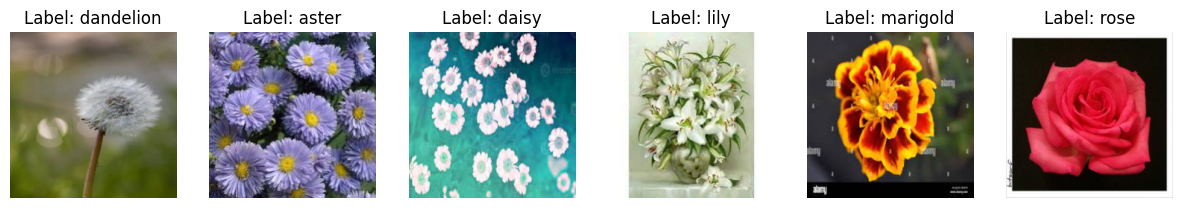

In [48]:
# Display some images from the training set

# Get a sample from the DataLoader
sample = next(iter(train_loader))

# Reverse the mapping to create index-to-class mapping
index_to_class_mapping = {index: class_name for class_name, index in train_loader.dataset.class_to_idx.items()}

# Display multiple images in a grid
num_images_to_display = 6
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))
for i in range(num_images_to_display):
    image = np.transpose(sample[0][i].numpy(), (1, 2, 0))
    label = sample[1][i].item()
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {index_to_class_mapping[label]}")
    axes[i].axis('off')

plt.show()

### Running Experiments

In [ ]:
# Define experiments
experiments = [
    {
        "name": "experiment_1",
        "batch_size": 16,
        "learning_rate": 0.0001,
        "num_epochs": 10,
    },
    {
        "name": "experiment_2",
        "batch_size": 32,
        "learning_rate": 0.0001,
        "num_epochs": 10,
    },
    {
        "name": "experiment_3",
        "batch_size": 64,
        "learning_rate": 0.0001,
        "num_epochs": 10,
    },
    {
        "name": "experiment_4",
        "batch_size": 32,
        "learning_rate": 0.0005,
        "num_epochs": 10,
    },
    {
        "name": "experiment_5",
        "batch_size": 64,
        "learning_rate": 0.0005,
        "num_epochs": 10,
    },
     {
        "name": "experiment_6",
        "batch_size": 32,
        "learning_rate": 0.00001,
        "num_epochs": 10,
    },
    {
        "name": "experiment_7",
        "batch_size": 64,
        "learning_rate": 0.00001,
        "num_epochs": 10,
    },
    {
        "name": "experiment_8",
        "batch_size": 32,
        "learning_rate": 0.00005,
        "num_epochs": 10,
    },
    {
        "name": "experiment_9",
        "batch_size": 64,
        "learning_rate": 0.00005,
        "num_epochs": 10,
    },
    {
        "name": "experiment_10",
        "batch_size": 64,
        "learning_rate": 0.000005,
        "num_epochs": 10,
    },

]

In [ ]:
# Set device
device = torch.device("mps")
# Set dataset path
dataset_folder = "flowers15"

#### Fine-tuning All Layers

Running experiment: experiment_1
model: VGG-19, layers_to_finetune: all_layers, learning_rate: 0.0001, batch_size: 16
Epoch [1/10], Training Loss: 1.2319610246136075, Validation Loss: 0.7716450473732418, Training Accuracy: 0.6171, Validation Accuracy: 0.7724
Epoch [2/10], Training Loss: 0.6431931163526716, Validation Loss: 0.9028639509826899, Training Accuracy: 0.8129, Validation Accuracy: 0.7369
Epoch [3/10], Training Loss: 0.4856125652023724, Validation Loss: 0.5966878957259986, Training Accuracy: 0.8590, Validation Accuracy: 0.8387
Epoch [4/10], Training Loss: 0.3907774977655638, Validation Loss: 0.5715180584134327, Training Accuracy: 0.8817, Validation Accuracy: 0.8467
Epoch [5/10], Training Loss: 0.3059578506744334, Validation Loss: 0.7015371178490524, Training Accuracy: 0.9088, Validation Accuracy: 0.8231
Epoch [6/10], Training Loss: 0.24688149814059338, Validation Loss: 0.7411570706334379, Training Accuracy: 0.9271, Validation Accuracy: 0.8022
Epoch [7/10], Training Loss: 0.2175

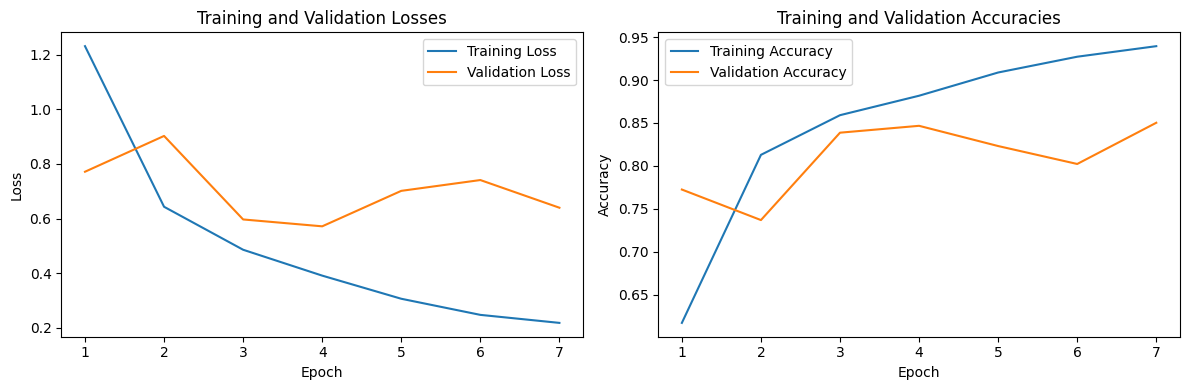

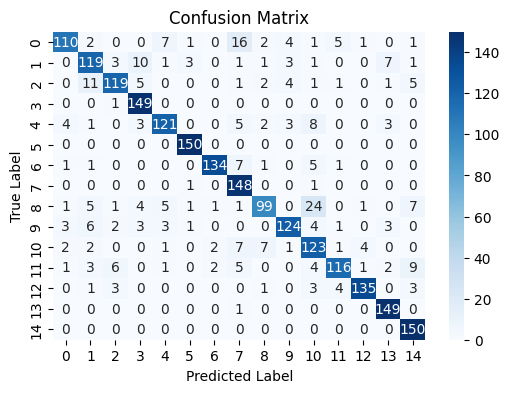

Accuracy: 0.8648888888888889
Precision: 0.8699564637374864
Recall: 0.8648888888888889
F1 Score: 0.8630975959210353
-------------------------------------------------

Running experiment: experiment_2
model: VGG-19, layers_to_finetune: all_layers, learning_rate: 0.0001, batch_size: 32
Epoch [1/10], Training Loss: 1.1106892827124824, Validation Loss: 0.8528483000122424, Training Accuracy: 0.6539, Validation Accuracy: 0.7636
Epoch [2/10], Training Loss: 0.5527951664584023, Validation Loss: 0.5939653155936135, Training Accuracy: 0.8352, Validation Accuracy: 0.8369
Epoch [3/10], Training Loss: 0.3801323628085, Validation Loss: 0.5178781820454945, Training Accuracy: 0.8860, Validation Accuracy: 0.8596
Epoch [4/10], Training Loss: 0.2794498338585808, Validation Loss: 0.5696032212707731, Training Accuracy: 0.9178, Validation Accuracy: 0.8533
Epoch [5/10], Training Loss: 0.22712435286030883, Validation Loss: 0.7303598430790007, Training Accuracy: 0.9297, Validation Accuracy: 0.8076
Epoch [6/10],

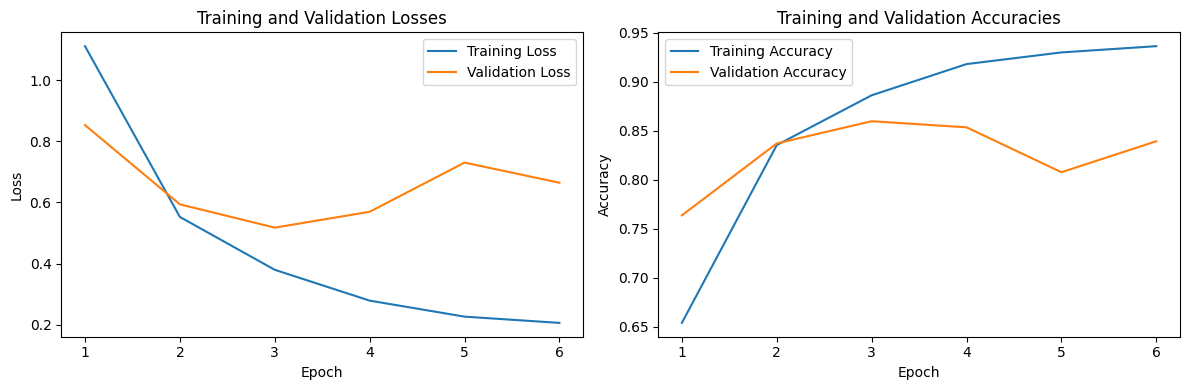

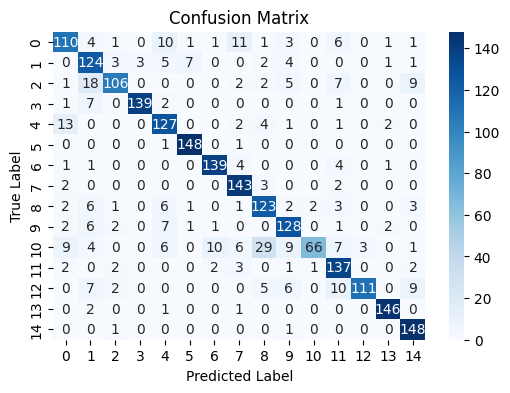

Accuracy: 0.8422222222222222
Precision: 0.8536060649477214
Recall: 0.8422222222222222
F1 Score: 0.8377377785621525
-------------------------------------------------

Running experiment: experiment_3
model: VGG-19, layers_to_finetune: all_layers, learning_rate: 0.0001, batch_size: 64
Epoch [1/10], Training Loss: 1.024414225396656, Validation Loss: 0.6972954580055343, Training Accuracy: 0.6874, Validation Accuracy: 0.7840
Epoch [2/10], Training Loss: 0.5180908148480313, Validation Loss: 0.5116324296394984, Training Accuracy: 0.8442, Validation Accuracy: 0.8507
Epoch [3/10], Training Loss: 0.2980924402446974, Validation Loss: 0.5598952356581058, Training Accuracy: 0.9058, Validation Accuracy: 0.8387
Epoch [4/10], Training Loss: 0.22650748738136497, Validation Loss: 0.4770033655497763, Training Accuracy: 0.9280, Validation Accuracy: 0.8658
Epoch [5/10], Training Loss: 0.1583977497986385, Validation Loss: 0.6197600689680419, Training Accuracy: 0.9501, Validation Accuracy: 0.8547
Epoch [6/10

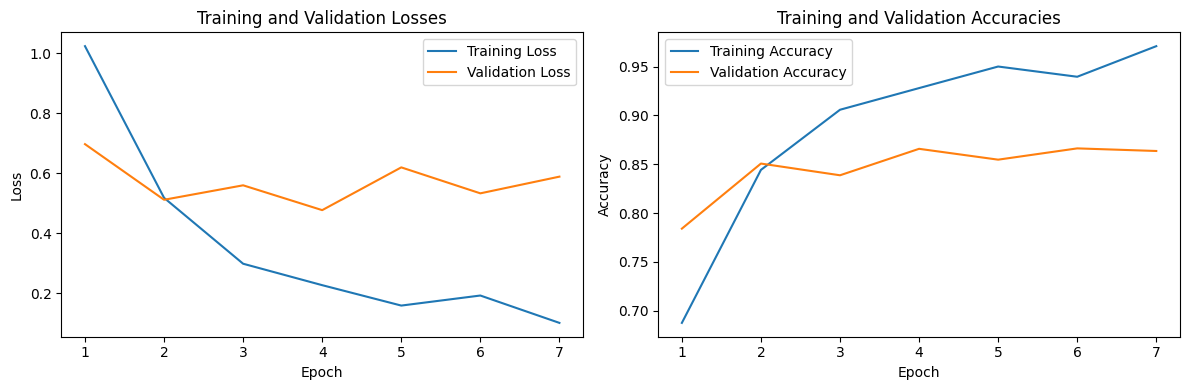

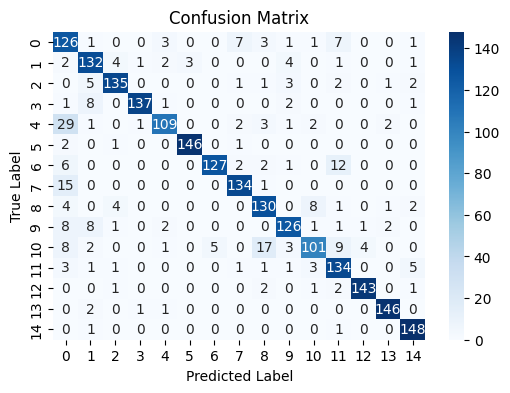

Accuracy: 0.8773333333333333
Precision: 0.8863416452028557
Recall: 0.8773333333333332
F1 Score: 0.8783905508344448
-------------------------------------------------

Running experiment: experiment_4
model: VGG-19, layers_to_finetune: all_layers, learning_rate: 0.0005, batch_size: 32
Epoch [1/10], Training Loss: 2.4743985533033097, Validation Loss: 2.8209651455349394, Training Accuracy: 0.1397, Validation Accuracy: 0.1418
Epoch [2/10], Training Loss: 2.177950157438006, Validation Loss: 1.9799199477301703, Training Accuracy: 0.2364, Validation Accuracy: 0.2867
Epoch [3/10], Training Loss: 1.9097166377476285, Validation Loss: 1.8710995131598578, Training Accuracy: 0.3154, Validation Accuracy: 0.3493
Epoch [4/10], Training Loss: 1.7722361551012311, Validation Loss: 1.7955473791758219, Training Accuracy: 0.3799, Validation Accuracy: 0.3813
Epoch [5/10], Training Loss: 1.6499169273830596, Validation Loss: 1.7093349024454754, Training Accuracy: 0.4209, Validation Accuracy: 0.4027
Epoch [6/10]

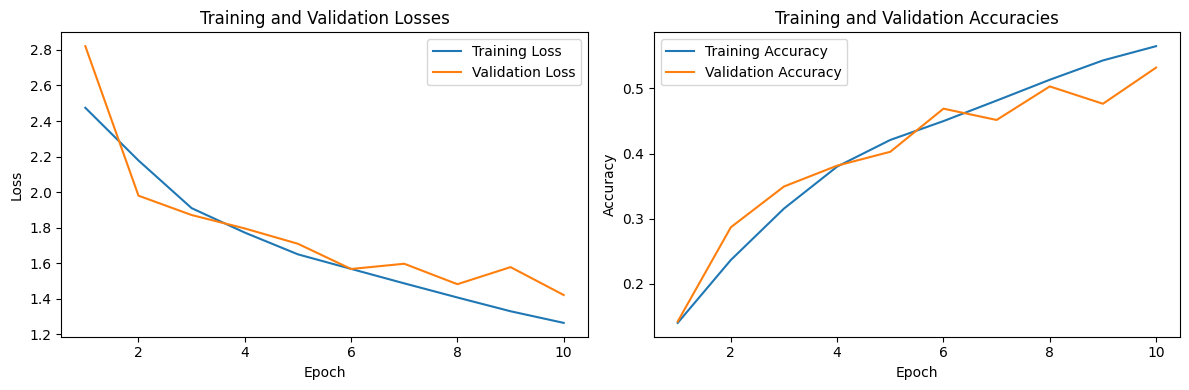

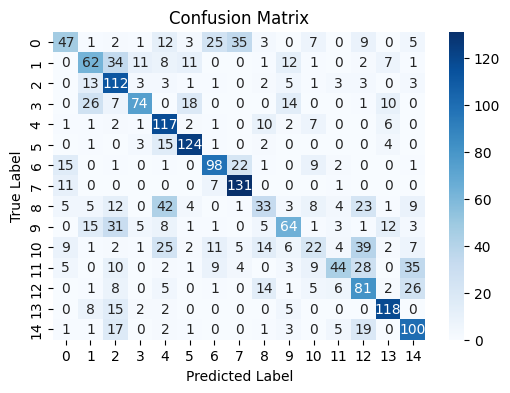

Accuracy: 0.5453333333333333
Precision: 0.54329774559412
Recall: 0.5453333333333332
F1 Score: 0.5260991272027472
-------------------------------------------------

Running experiment: experiment_5
model: VGG-19, layers_to_finetune: all_layers, learning_rate: 0.0005, batch_size: 64
Epoch [1/10], Training Loss: 2.3192845068432035, Validation Loss: 2.131741898006863, Training Accuracy: 0.1743, Validation Accuracy: 0.2387
Epoch [2/10], Training Loss: 1.9662362630480812, Validation Loss: 1.946104280789693, Training Accuracy: 0.2963, Validation Accuracy: 0.3458
Epoch [3/10], Training Loss: 1.7661612831297375, Validation Loss: 2.138530289332072, Training Accuracy: 0.3832, Validation Accuracy: 0.2898
Epoch [4/10], Training Loss: 1.5989226054237002, Validation Loss: 1.5281587288644578, Training Accuracy: 0.4433, Validation Accuracy: 0.4920
Epoch [5/10], Training Loss: 1.4139947876703172, Validation Loss: 1.4925448229047986, Training Accuracy: 0.5151, Validation Accuracy: 0.5076
Epoch [6/10], Tr

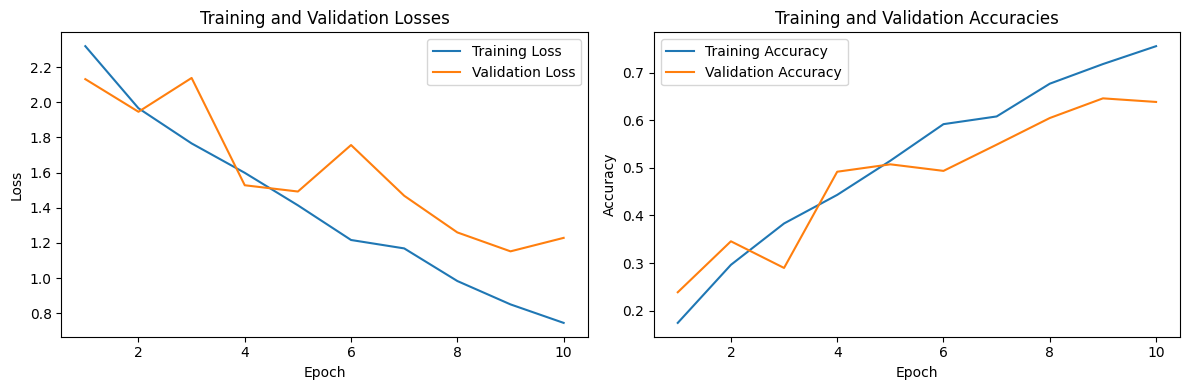

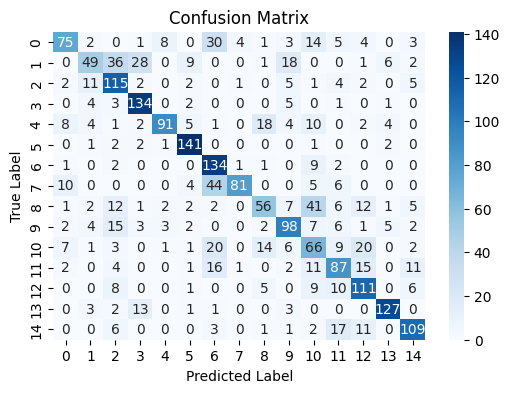

Accuracy: 0.6551111111111111
Precision: 0.6735428571383473
Recall: 0.6551111111111112
F1 Score: 0.6488135586115873
-------------------------------------------------

Running experiment: experiment_6
model: VGG-19, layers_to_finetune: all_layers, learning_rate: 1e-05, batch_size: 32
Epoch [1/10], Training Loss: 1.4388209469886053, Validation Loss: 0.6593152086999682, Training Accuracy: 0.5513, Validation Accuracy: 0.7964
Epoch [2/10], Training Loss: 0.6170165024257842, Validation Loss: 0.5415768395662308, Training Accuracy: 0.8108, Validation Accuracy: 0.8351
Epoch [3/10], Training Loss: 0.4256140454184441, Validation Loss: 0.48264634608891277, Training Accuracy: 0.8720, Validation Accuracy: 0.8556
Epoch [4/10], Training Loss: 0.29870654446454276, Validation Loss: 0.4621864741179678, Training Accuracy: 0.9069, Validation Accuracy: 0.8622
Epoch [5/10], Training Loss: 0.20448249919073921, Validation Loss: 0.4577880698707369, Training Accuracy: 0.9374, Validation Accuracy: 0.8702
Epoch [6/

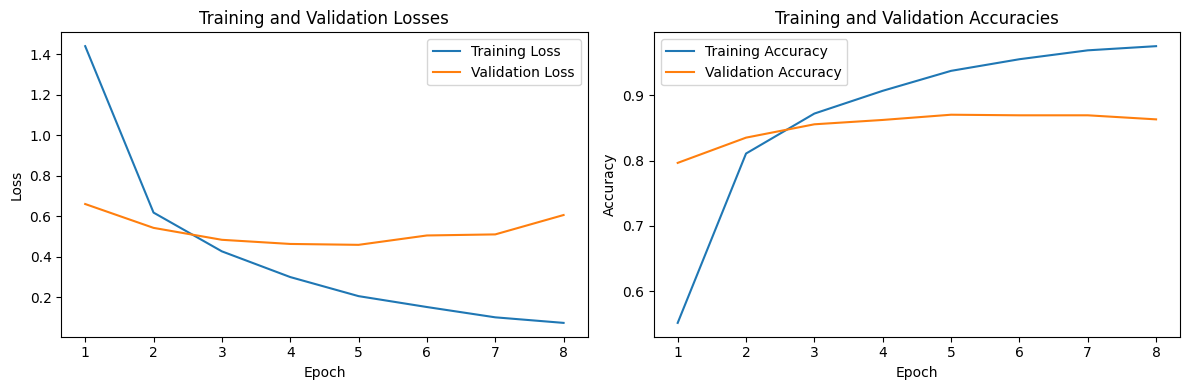

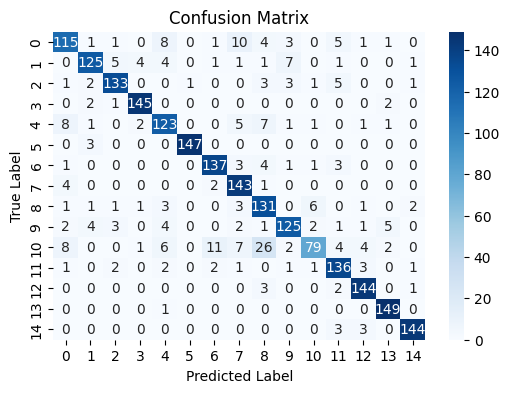

Accuracy: 0.8782222222222222
Precision: 0.8804518543098638
Recall: 0.8782222222222221
F1 Score: 0.8753668243299745
-------------------------------------------------

Running experiment: experiment_7
model: VGG-19, layers_to_finetune: all_layers, learning_rate: 1e-05, batch_size: 64
Epoch [1/10], Training Loss: 1.701096973101298, Validation Loss: 0.7832760400507185, Training Accuracy: 0.4615, Validation Accuracy: 0.7680
Epoch [2/10], Training Loss: 0.7401987085569472, Validation Loss: 0.5606662533283233, Training Accuracy: 0.7754, Validation Accuracy: 0.8333
Epoch [3/10], Training Loss: 0.522316744917915, Validation Loss: 0.5197074488268958, Training Accuracy: 0.8421, Validation Accuracy: 0.8484
Epoch [4/10], Training Loss: 0.3858118166526159, Validation Loss: 0.4824986909363005, Training Accuracy: 0.8821, Validation Accuracy: 0.8524
Epoch [5/10], Training Loss: 0.2919769239986227, Validation Loss: 0.47658047038979, Training Accuracy: 0.9100, Validation Accuracy: 0.8649
Epoch [6/10], Tr

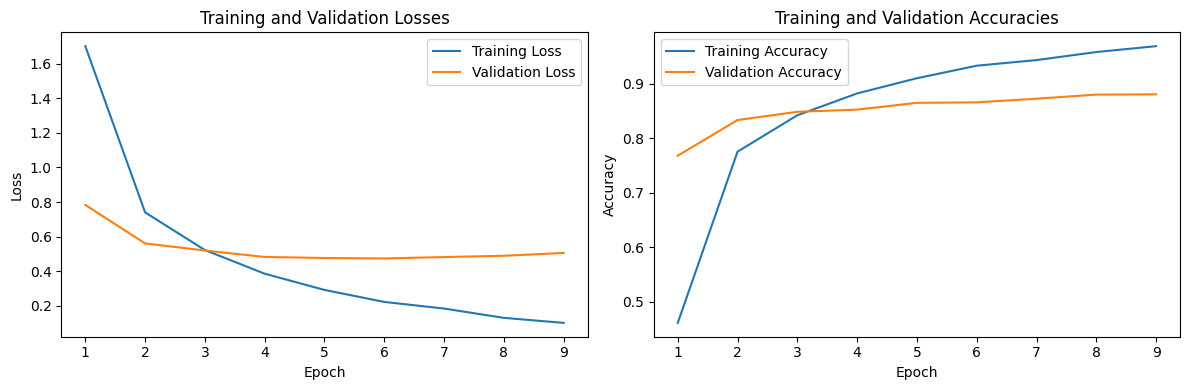

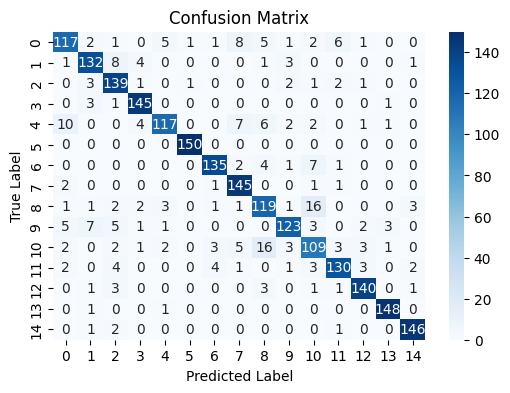

Accuracy: 0.8866666666666667
Precision: 0.8869358544045917
Recall: 0.8866666666666666
F1 Score: 0.88579500244375
-------------------------------------------------

Running experiment: experiment_8
model: VGG-19, layers_to_finetune: all_layers, learning_rate: 5e-05, batch_size: 32
Epoch [1/10], Training Loss: 1.1099683294750395, Validation Loss: 0.7552451499038273, Training Accuracy: 0.6562, Validation Accuracy: 0.7707
Epoch [2/10], Training Loss: 0.4807103014219375, Validation Loss: 0.5430116752568218, Training Accuracy: 0.8559, Validation Accuracy: 0.8418
Epoch [3/10], Training Loss: 0.3051573464529855, Validation Loss: 0.5558343584839669, Training Accuracy: 0.9070, Validation Accuracy: 0.8480
Epoch [4/10], Training Loss: 0.1936577987245151, Validation Loss: 0.5736500115229024, Training Accuracy: 0.9370, Validation Accuracy: 0.8471
Epoch [5/10], Training Loss: 0.14404926607438495, Validation Loss: 0.5940197363859301, Training Accuracy: 0.9543, Validation Accuracy: 0.8622
Early stoppin

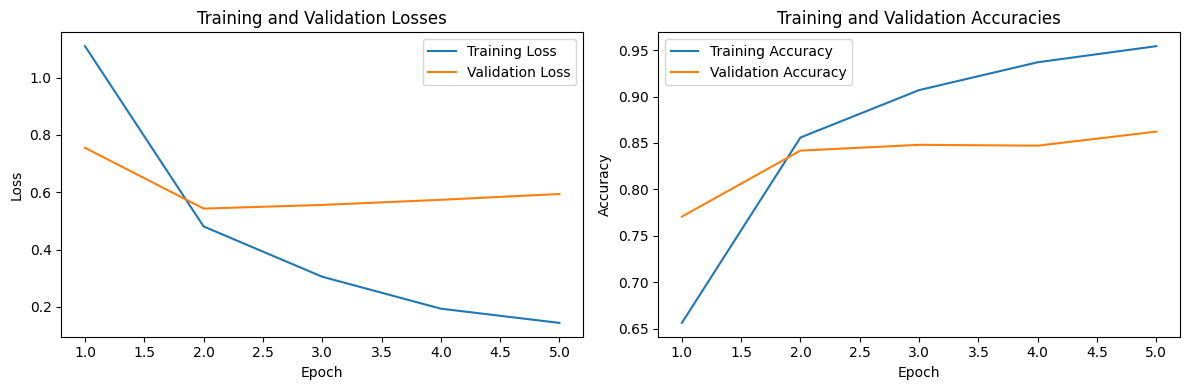

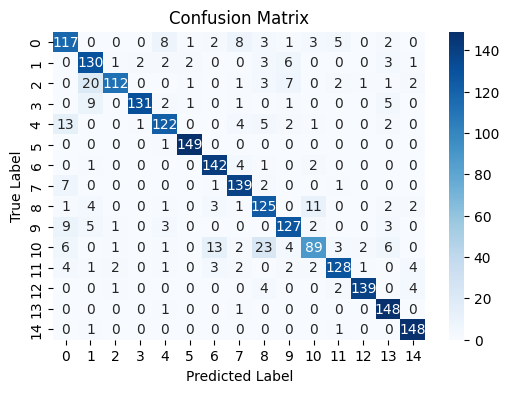

Accuracy: 0.8648888888888889
Precision: 0.8684054577431548
Recall: 0.8648888888888887
F1 Score: 0.8633719396041759
-------------------------------------------------

Running experiment: experiment_9
model: VGG-19, layers_to_finetune: all_layers, learning_rate: 5e-05, batch_size: 64
Epoch [1/10], Training Loss: 1.0783041586421784, Validation Loss: 0.6146296787791782, Training Accuracy: 0.6722, Validation Accuracy: 0.8213
Epoch [2/10], Training Loss: 0.4434014531970024, Validation Loss: 0.5250657684389088, Training Accuracy: 0.8682, Validation Accuracy: 0.8507
Epoch [3/10], Training Loss: 0.27083890841120767, Validation Loss: 0.514327903446224, Training Accuracy: 0.9174, Validation Accuracy: 0.8551
Epoch [4/10], Training Loss: 0.17096095602569125, Validation Loss: 0.5538329680760702, Training Accuracy: 0.9462, Validation Accuracy: 0.8631
Epoch [5/10], Training Loss: 0.12497394536045335, Validation Loss: 0.5136280888186561, Training Accuracy: 0.9596, Validation Accuracy: 0.8676
Epoch [6/1

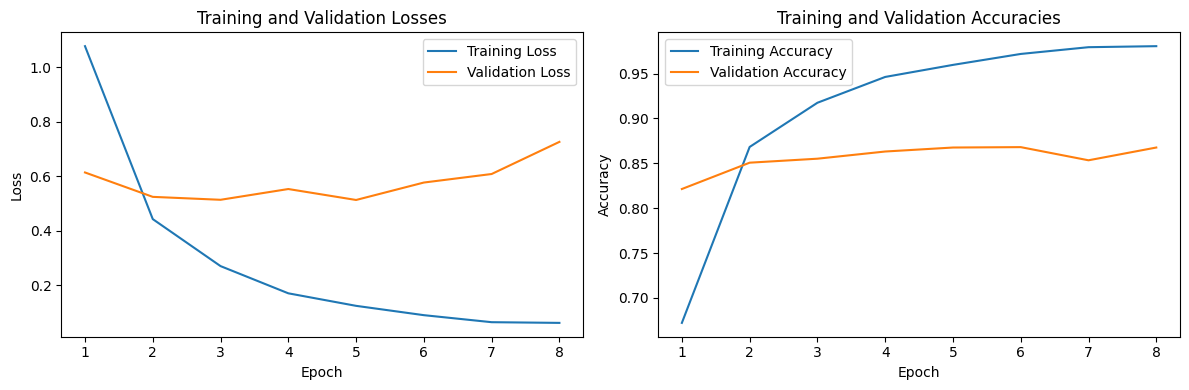

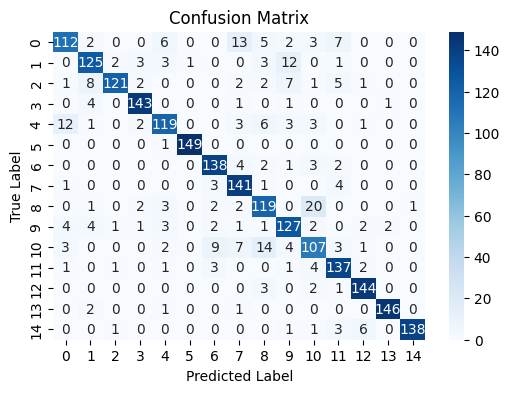

Accuracy: 0.8737777777777778
Precision: 0.8760041182632172
Recall: 0.8737777777777775
F1 Score: 0.8735093558068971
-------------------------------------------------

Running experiment: experiment_10
model: VGG-19, layers_to_finetune: all_layers, learning_rate: 5e-06, batch_size: 64
Epoch [1/10], Training Loss: 2.160079187211536, Validation Loss: 1.1884065665139092, Training Accuracy: 0.3197, Validation Accuracy: 0.6431
Epoch [2/10], Training Loss: 1.0855500532104856, Validation Loss: 0.770909688923094, Training Accuracy: 0.6674, Validation Accuracy: 0.7733
Epoch [3/10], Training Loss: 0.7663342176846095, Validation Loss: 0.6534909874068366, Training Accuracy: 0.7657, Validation Accuracy: 0.8000
Epoch [4/10], Training Loss: 0.6115971448307945, Validation Loss: 0.5838187540637122, Training Accuracy: 0.8184, Validation Accuracy: 0.8236
Epoch [5/10], Training Loss: 0.5120510154678708, Validation Loss: 0.5605151611169179, Training Accuracy: 0.8456, Validation Accuracy: 0.8382
Epoch [6/10],

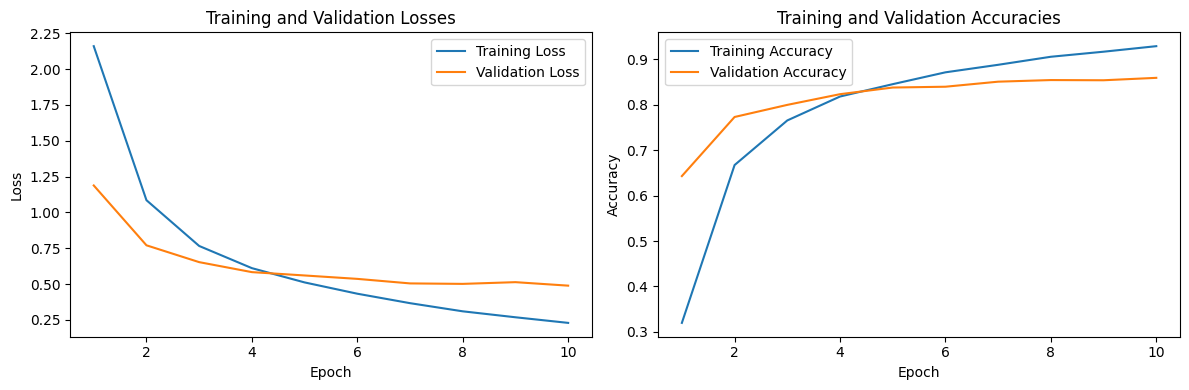

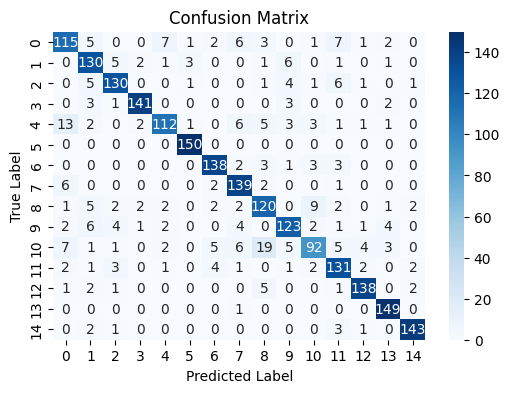

Accuracy: 0.8671111111111112
Precision: 0.867145982823527
Recall: 0.867111111111111
F1 Score: 0.8652723716217097
-------------------------------------------------



In [ ]:
results_all_layers = []

# Finetune all layers of the VGG19 model
for experiment in experiments:
    print(f"Running experiment: {experiment['name']}")
    print(f"model: VGG-19, layers_to_finetune: all_layers, learning_rate: {experiment['learning_rate']}, batch_size: {experiment['batch_size']}")
    # Finetune and evaluate the model
    metrics = finetune_and_evaluate_model(
        model=models.vgg19(weights=models.VGG19_Weights.DEFAULT),
        which_layers='all_layers',
        num_epochs=experiment['num_epochs'],
        learning_rate=experiment['learning_rate'],
        batch_size=experiment['batch_size'],
        experiment_name=experiment['name'],
        dataset_path=dataset_folder,
        device=device)
    # Append to the list
    experiment.update(metrics)
    results_all_layers.append(experiment)
    print("-------------------------------------------------\n")

#### Fine-tuning Fully Connected Layers

Running experiment: experiment_1
model: VGG-19, layers_to_finetune: fc1_and_fc2, learning_rate: 0.0001, batch_size: 16
Epoch [1/10], Training Loss: 1.2165688610531036, Validation Loss: 0.8552578523953756, Training Accuracy: 0.6119, Validation Accuracy: 0.7276
Epoch [2/10], Training Loss: 0.5938346804777781, Validation Loss: 0.769676350235939, Training Accuracy: 0.8087, Validation Accuracy: 0.7564
Epoch [3/10], Training Loss: 0.3046692404995362, Validation Loss: 0.8387926804315713, Training Accuracy: 0.9054, Validation Accuracy: 0.7516
Epoch [4/10], Training Loss: 0.17258475767856551, Validation Loss: 0.9607816340671852, Training Accuracy: 0.9449, Validation Accuracy: 0.7556
Epoch [5/10], Training Loss: 0.11846396818561923, Validation Loss: 1.0086716282867516, Training Accuracy: 0.9611, Validation Accuracy: 0.7631
Early stopping after 5 epochs. The model did not improve for 3 consecutive epochs.


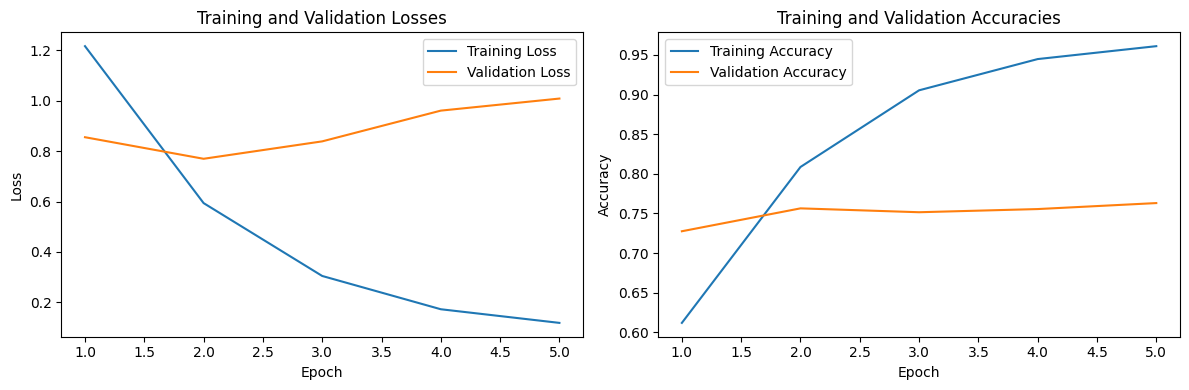

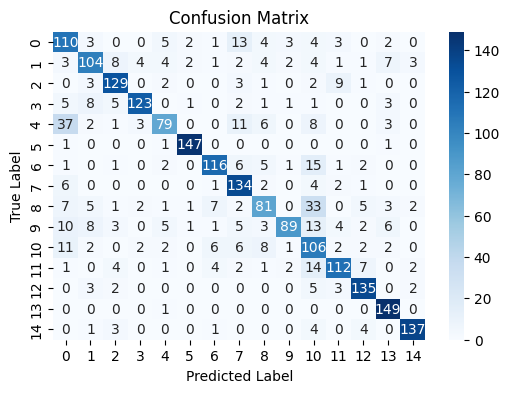

Accuracy: 0.7782222222222223
Precision: 0.7922909221719825
Recall: 0.7782222222222223
F1 Score: 0.7775678386401588
-------------------------------------------------

Running experiment: experiment_2
model: VGG-19, layers_to_finetune: fc1_and_fc2, learning_rate: 0.0001, batch_size: 32
Epoch [1/10], Training Loss: 1.2538179473649889, Validation Loss: 0.8504785345395406, Training Accuracy: 0.6011, Validation Accuracy: 0.7338
Epoch [2/10], Training Loss: 0.6030833914620536, Validation Loss: 0.769486974451277, Training Accuracy: 0.8097, Validation Accuracy: 0.7516
Epoch [3/10], Training Loss: 0.3244856301801545, Validation Loss: 0.7612204808129205, Training Accuracy: 0.8990, Validation Accuracy: 0.7684
Epoch [4/10], Training Loss: 0.15264560429538998, Validation Loss: 0.8025571331381798, Training Accuracy: 0.9523, Validation Accuracy: 0.7751
Epoch [5/10], Training Loss: 0.09305928911623501, Validation Loss: 0.9716300359744993, Training Accuracy: 0.9708, Validation Accuracy: 0.7627
Epoch [6/

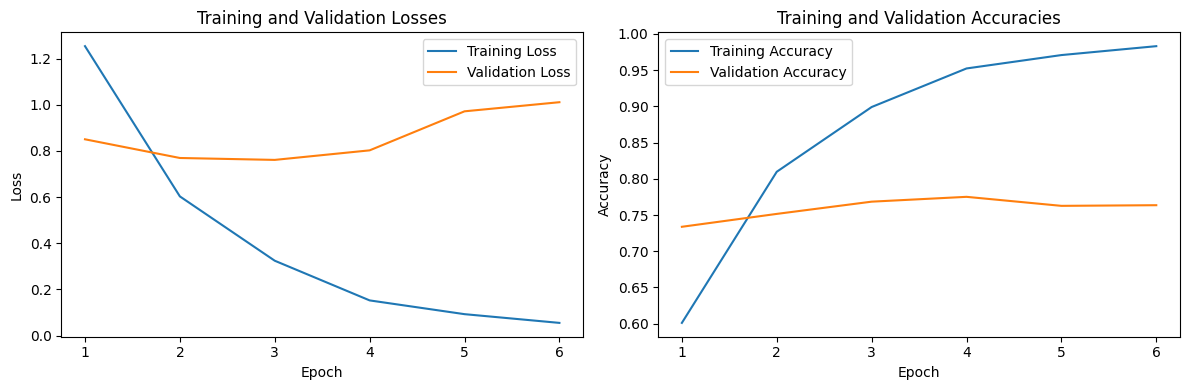

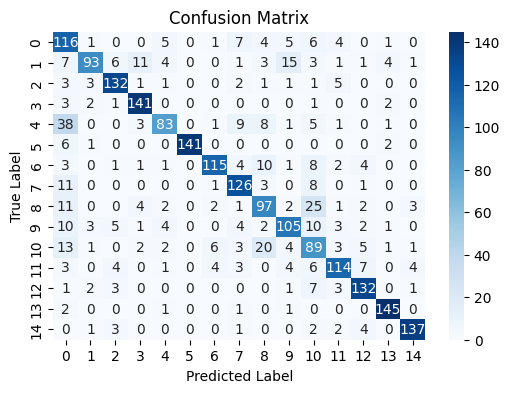

Accuracy: 0.7848888888888889
Precision: 0.7992674008831063
Recall: 0.7848888888888889
F1 Score: 0.7864957077650337
-------------------------------------------------

Running experiment: experiment_3
model: VGG-19, layers_to_finetune: fc1_and_fc2, learning_rate: 0.0001, batch_size: 64
Epoch [1/10], Training Loss: 1.309156349908738, Validation Loss: 0.854922887192832, Training Accuracy: 0.5874, Validation Accuracy: 0.7329
Epoch [2/10], Training Loss: 0.6398586706433977, Validation Loss: 0.7325434367722935, Training Accuracy: 0.7987, Validation Accuracy: 0.7667
Epoch [3/10], Training Loss: 0.3544706856069111, Validation Loss: 0.7121530553897222, Training Accuracy: 0.8896, Validation Accuracy: 0.7809
Epoch [4/10], Training Loss: 0.17995845989953904, Validation Loss: 0.795007607801093, Training Accuracy: 0.9440, Validation Accuracy: 0.7747
Epoch [5/10], Training Loss: 0.09578067508960764, Validation Loss: 0.8315420618553956, Training Accuracy: 0.9735, Validation Accuracy: 0.7769
Epoch [6/10

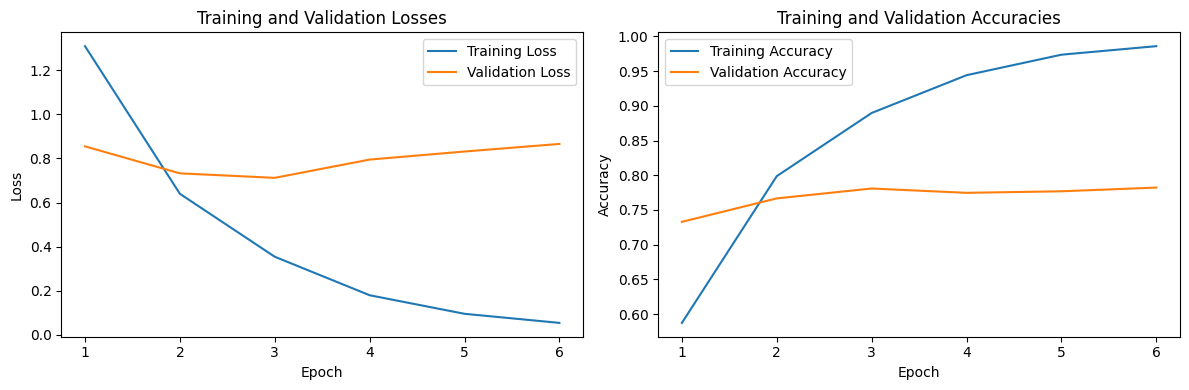

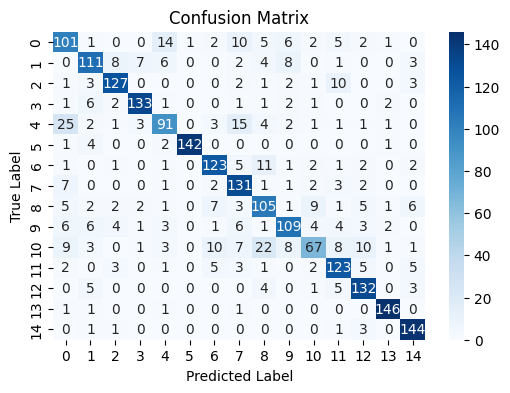

Accuracy: 0.7933333333333333
Precision: 0.7936668156290895
Recall: 0.7933333333333332
F1 Score: 0.7896543787412631
-------------------------------------------------

Running experiment: experiment_4
model: VGG-19, layers_to_finetune: fc1_and_fc2, learning_rate: 0.0005, batch_size: 32
Epoch [1/10], Training Loss: 1.3631276558864684, Validation Loss: 1.0391483443048266, Training Accuracy: 0.5753, Validation Accuracy: 0.6787
Epoch [2/10], Training Loss: 0.7682556574685233, Validation Loss: 0.9060580648316278, Training Accuracy: 0.7635, Validation Accuracy: 0.7320
Epoch [3/10], Training Loss: 0.5353646305373737, Validation Loss: 0.9350843174954255, Training Accuracy: 0.8372, Validation Accuracy: 0.7427
Epoch [4/10], Training Loss: 0.4374790862145878, Validation Loss: 1.051153695412808, Training Accuracy: 0.8723, Validation Accuracy: 0.7329
Epoch [5/10], Training Loss: 0.3377272277772427, Validation Loss: 1.0270432504659726, Training Accuracy: 0.9023, Validation Accuracy: 0.7569
Early stopp

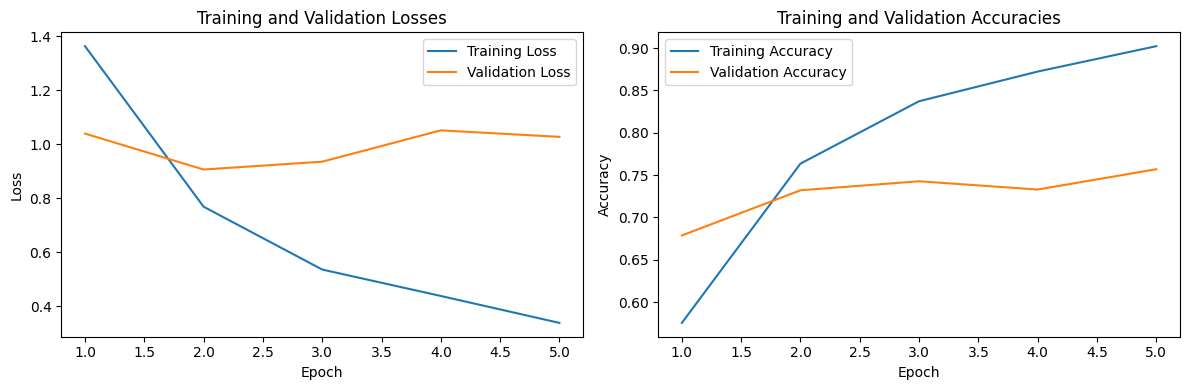

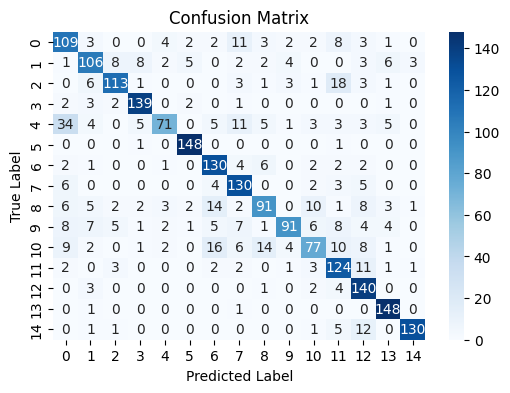

Accuracy: 0.7764444444444445
Precision: 0.7849810506068297
Recall: 0.7764444444444444
F1 Score: 0.7708129010707254
-------------------------------------------------

Running experiment: experiment_5
model: VGG-19, layers_to_finetune: fc1_and_fc2, learning_rate: 0.0005, batch_size: 64
Epoch [1/10], Training Loss: 1.2840025208791097, Validation Loss: 0.9695325117111206, Training Accuracy: 0.5916, Validation Accuracy: 0.6911
Epoch [2/10], Training Loss: 0.6650875048438708, Validation Loss: 0.949529461728202, Training Accuracy: 0.7881, Validation Accuracy: 0.7196
Epoch [3/10], Training Loss: 0.42969514977364315, Validation Loss: 0.8955148671236303, Training Accuracy: 0.8625, Validation Accuracy: 0.7484
Epoch [4/10], Training Loss: 0.31819427705094927, Validation Loss: 1.0311421154207654, Training Accuracy: 0.8994, Validation Accuracy: 0.7436
Epoch [5/10], Training Loss: 0.21922175089518228, Validation Loss: 1.0574669512386123, Training Accuracy: 0.9331, Validation Accuracy: 0.7507
Epoch [6

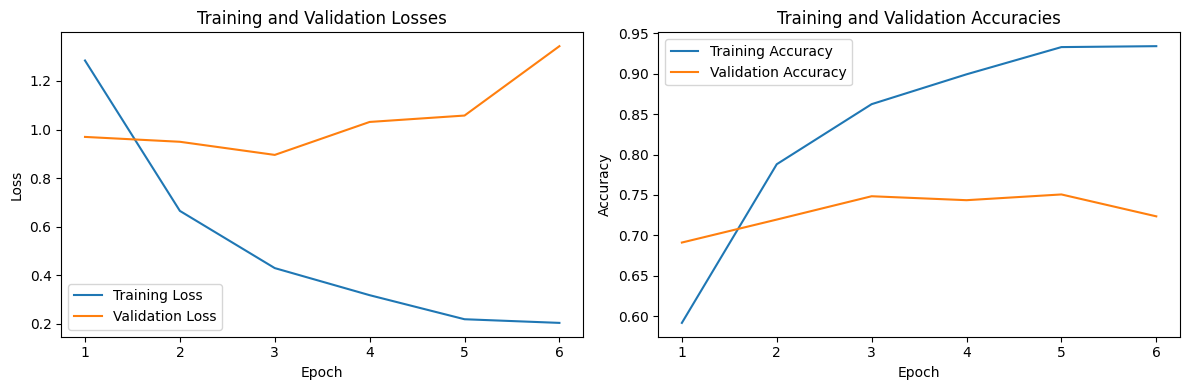

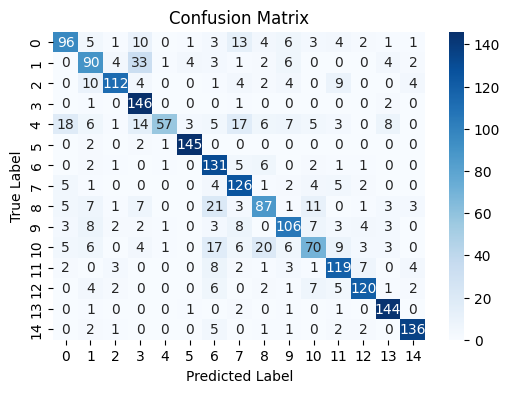

Accuracy: 0.7488888888888889
Precision: 0.7597543915303464
Recall: 0.7488888888888889
F1 Score: 0.7410208203794728
-------------------------------------------------

Running experiment: experiment_6
model: VGG-19, layers_to_finetune: fc1_and_fc2, learning_rate: 1e-05, batch_size: 32
Epoch [1/10], Training Loss: 2.0436928496587843, Validation Loss: 1.3428164915508694, Training Accuracy: 0.3705, Validation Accuracy: 0.6142
Epoch [2/10], Training Loss: 1.2242105850038074, Validation Loss: 1.0059169833395216, Training Accuracy: 0.6211, Validation Accuracy: 0.7036
Epoch [3/10], Training Loss: 0.9562157504672096, Validation Loss: 0.8963545345995161, Training Accuracy: 0.7059, Validation Accuracy: 0.7338
Epoch [4/10], Training Loss: 0.7960630331493559, Validation Loss: 0.8297481211556329, Training Accuracy: 0.7569, Validation Accuracy: 0.7520
Epoch [5/10], Training Loss: 0.6734084595385051, Validation Loss: 0.7788455324437883, Training Accuracy: 0.7954, Validation Accuracy: 0.7596
Epoch [6/10

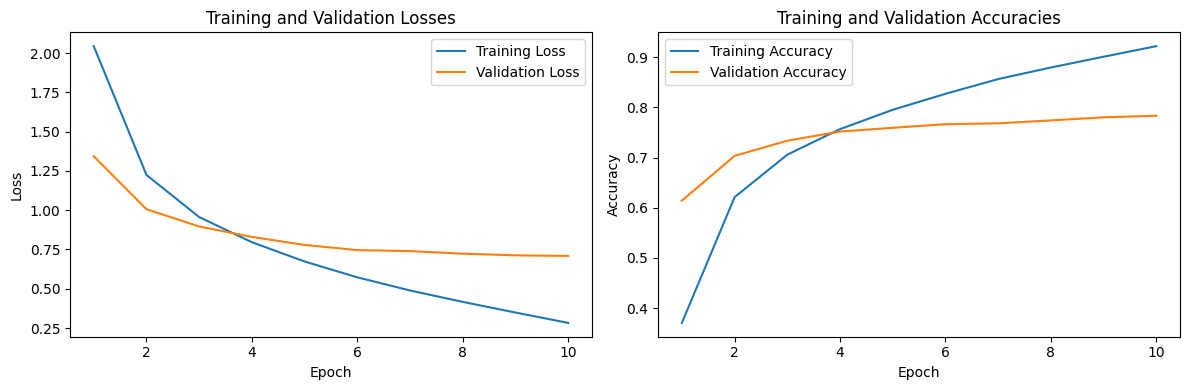

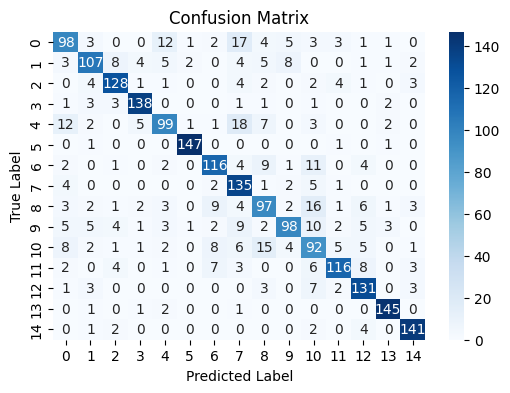

Accuracy: 0.7946666666666666
Precision: 0.7977191057722058
Recall: 0.7946666666666666
F1 Score: 0.7934455701150932
-------------------------------------------------

Running experiment: experiment_7
model: VGG-19, layers_to_finetune: fc1_and_fc2, learning_rate: 1e-05, batch_size: 64
Epoch [1/10], Training Loss: 2.235317087355114, Validation Loss: 1.5849120180341933, Training Accuracy: 0.3123, Validation Accuracy: 0.5849
Epoch [2/10], Training Loss: 1.4254155991872153, Validation Loss: 1.1515741288926866, Training Accuracy: 0.5640, Validation Accuracy: 0.6684
Epoch [3/10], Training Loss: 1.1208038978463128, Validation Loss: 0.9939718199306065, Training Accuracy: 0.6550, Validation Accuracy: 0.7080
Epoch [4/10], Training Loss: 0.9413990418570383, Validation Loss: 0.9073814820448558, Training Accuracy: 0.7115, Validation Accuracy: 0.7280
Epoch [5/10], Training Loss: 0.8217527179661251, Validation Loss: 0.8490818360646566, Training Accuracy: 0.7517, Validation Accuracy: 0.7409
Epoch [6/10]

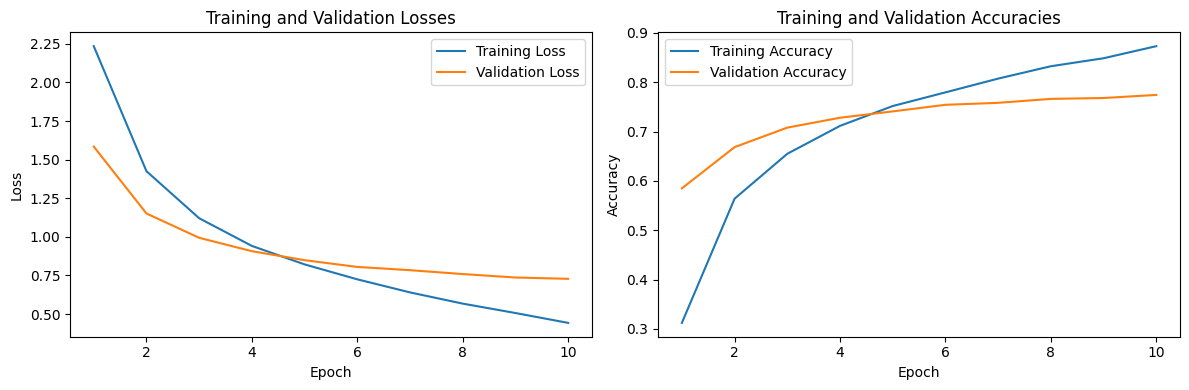

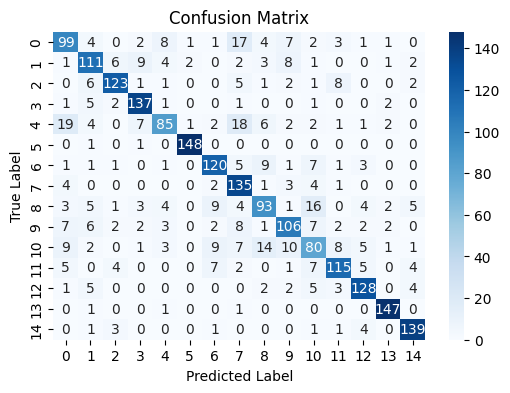

Accuracy: 0.7848888888888889
Precision: 0.7845388079838496
Recall: 0.784888888888889
F1 Score: 0.7819260114358909
-------------------------------------------------

Running experiment: experiment_8
model: VGG-19, layers_to_finetune: fc1_and_fc2, learning_rate: 5e-05, batch_size: 32
Epoch [1/10], Training Loss: 1.3584181740624564, Validation Loss: 0.8711185965008206, Training Accuracy: 0.5787, Validation Accuracy: 0.7298
Epoch [2/10], Training Loss: 0.690248994509379, Validation Loss: 0.7522947131792704, Training Accuracy: 0.7849, Validation Accuracy: 0.7627
Epoch [3/10], Training Loss: 0.41289753886063896, Validation Loss: 0.7196179192198647, Training Accuracy: 0.8718, Validation Accuracy: 0.7778
Epoch [4/10], Training Loss: 0.23630056059928167, Validation Loss: 0.719435692999098, Training Accuracy: 0.9309, Validation Accuracy: 0.7822
Epoch [5/10], Training Loss: 0.12247339877592665, Validation Loss: 0.7827890216906865, Training Accuracy: 0.9670, Validation Accuracy: 0.7778
Epoch [6/10

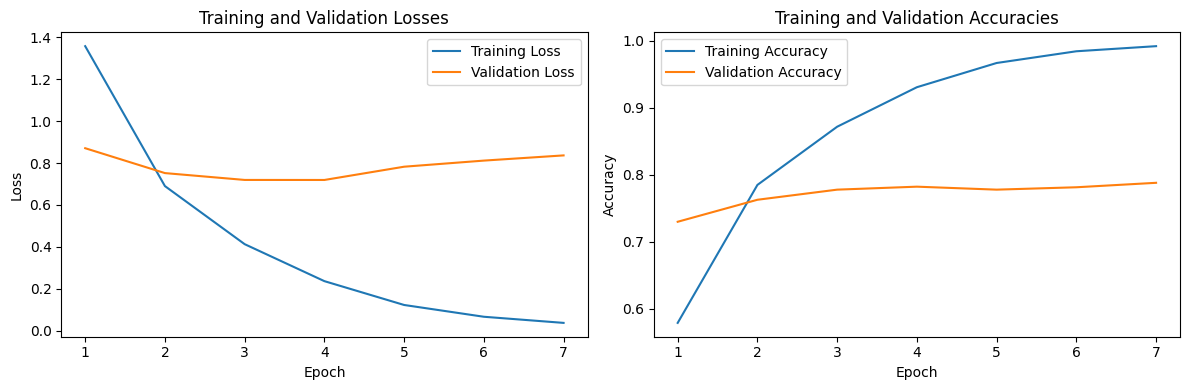

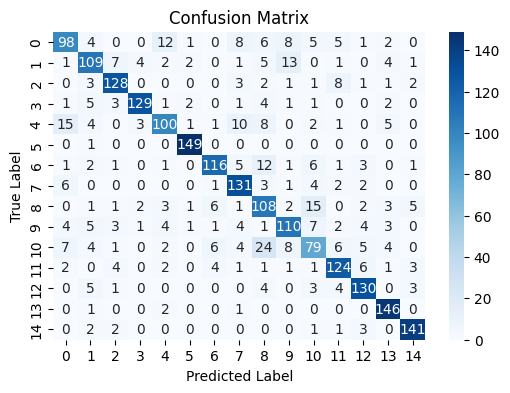

Accuracy: 0.7991111111111111
Precision: 0.7986777234837213
Recall: 0.7991111111111111
F1 Score: 0.7970216143730181
-------------------------------------------------

Running experiment: experiment_9
model: VGG-19, layers_to_finetune: fc1_and_fc2, learning_rate: 5e-05, batch_size: 64
Epoch [1/10], Training Loss: 1.4709499082111177, Validation Loss: 0.9499724731710222, Training Accuracy: 0.5418, Validation Accuracy: 0.7107
Epoch [2/10], Training Loss: 0.7871244163059054, Validation Loss: 0.7769626796642939, Training Accuracy: 0.7532, Validation Accuracy: 0.7542
Epoch [3/10], Training Loss: 0.5147116675078869, Validation Loss: 0.7256487059195836, Training Accuracy: 0.8397, Validation Accuracy: 0.7720
Epoch [4/10], Training Loss: 0.33034427931195215, Validation Loss: 0.7161508141888513, Training Accuracy: 0.9021, Validation Accuracy: 0.7764
Epoch [5/10], Training Loss: 0.1977091646194458, Validation Loss: 0.7178368769751655, Training Accuracy: 0.9458, Validation Accuracy: 0.7818
Epoch [6/1

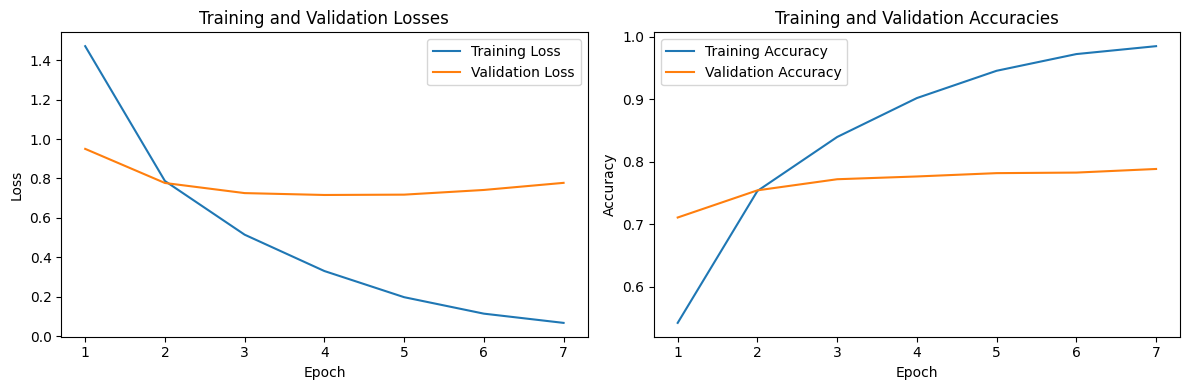

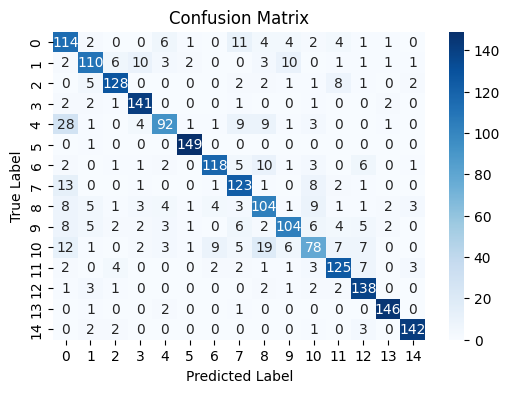

Accuracy: 0.8053333333333333
Precision: 0.8075069284343724
Recall: 0.8053333333333333
F1 Score: 0.8031978430913438
-------------------------------------------------

Running experiment: experiment_10
model: VGG-19, layers_to_finetune: fc1_and_fc2, learning_rate: 5e-06, batch_size: 64
Epoch [1/10], Training Loss: 2.48699135135469, Validation Loss: 2.1064817922380237, Training Accuracy: 0.2186, Validation Accuracy: 0.4809
Epoch [2/10], Training Loss: 1.8889405133837744, Validation Loss: 1.5592545149591235, Training Accuracy: 0.4431, Validation Accuracy: 0.5787
Epoch [3/10], Training Loss: 1.4968889499845959, Validation Loss: 1.2890092284944323, Training Accuracy: 0.5490, Validation Accuracy: 0.6342
Epoch [4/10], Training Loss: 1.2732881701333183, Validation Loss: 1.137975325372484, Training Accuracy: 0.6125, Validation Accuracy: 0.6756
Epoch [5/10], Training Loss: 1.1373704855782645, Validation Loss: 1.0515673815409343, Training Accuracy: 0.6547, Validation Accuracy: 0.6938
Epoch [6/10],

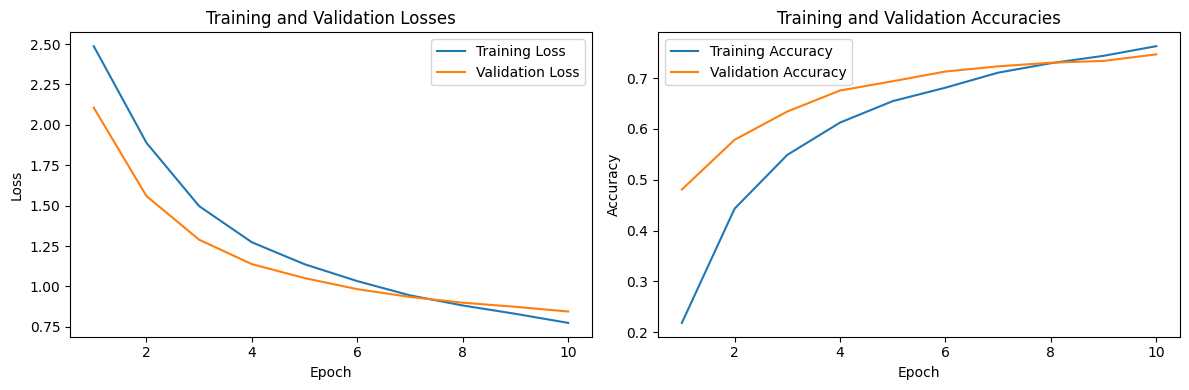

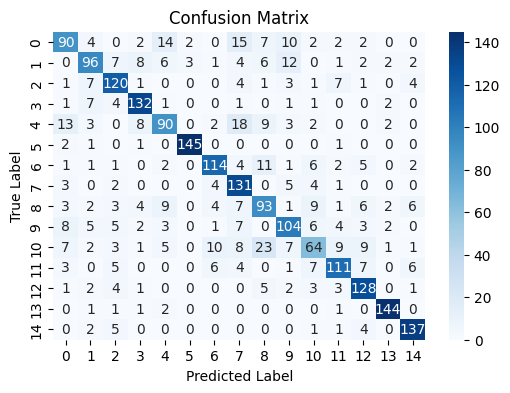

Accuracy: 0.7551111111111111
Precision: 0.7526712506378365
Recall: 0.7551111111111112
F1 Score: 0.7508258647879446
-------------------------------------------------



In [ ]:
results_fc1_and_fc2 = []

# Finetune only the fully connected layers of the VGG19 model
for experiment in experiments:
    print(f"Running experiment: {experiment['name']}")
    print(f"model: VGG-19, layers_to_finetune: fc1_and_fc2, learning_rate: {experiment['learning_rate']}, batch_size: {experiment['batch_size']}")
    # Finetune and evaluate the model
    metrics = finetune_and_evaluate_model(
        model=models.vgg19(weights=models.VGG19_Weights.DEFAULT),
        which_layers='fc1_and_fc2',
        num_epochs=experiment['num_epochs'],
        learning_rate=experiment['learning_rate'],
        batch_size=experiment['batch_size'],
        experiment_name=experiment['name'],
        dataset_path=dataset_folder,
        device=device)
    # Append to the list
    experiment.update(metrics)
    results_fc1_and_fc2.append(experiment)
    print("-------------------------------------------------\n")

### Results

In [ ]:
results_all_layers = [{'name': 'experiment_1', 'batch_size': 16, 'learning_rate': 0.0001, 'num_epochs': 10, 'Accuracy': 0.8648888888888889, 'Precision': 0.8699564637374864, 'Recall': 0.8648888888888889, 'F1 Score': 0.8630975959210353}, {'name': 'experiment_2', 'batch_size': 32, 'learning_rate': 0.0001, 'num_epochs': 10, 'Accuracy': 0.8422222222222222, 'Precision': 0.8536060649477214, 'Recall': 0.8422222222222222, 'F1 Score': 0.8377377785621525}, {'name': 'experiment_3', 'batch_size': 64, 'learning_rate': 0.0001, 'num_epochs': 10, 'Accuracy': 0.8773333333333333, 'Precision': 0.8863416452028557, 'Recall': 0.8773333333333332, 'F1 Score': 0.8783905508344448}, {'name': 'experiment_4', 'batch_size': 32, 'learning_rate': 0.0005, 'num_epochs': 10, 'Accuracy': 0.5453333333333333, 'Precision': 0.54329774559412, 'Recall': 0.5453333333333332, 'F1 Score': 0.5260991272027472}, {'name': 'experiment_5', 'batch_size': 64, 'learning_rate': 0.0005, 'num_epochs': 10, 'Accuracy': 0.6551111111111111, 'Precision': 0.6735428571383473, 'Recall': 0.6551111111111112, 'F1 Score': 0.6488135586115873}, {'name': 'experiment_6', 'batch_size': 32, 'learning_rate': 1e-05, 'num_epochs': 10, 'Accuracy': 0.8782222222222222, 'Precision': 0.8804518543098638, 'Recall': 0.8782222222222221, 'F1 Score': 0.8753668243299745}, {'name': 'experiment_7', 'batch_size': 64, 'learning_rate': 1e-05, 'num_epochs': 10, 'Accuracy': 0.8866666666666667, 'Precision': 0.8869358544045917, 'Recall': 0.8866666666666666, 'F1 Score': 0.88579500244375}, {'name': 'experiment_8', 'batch_size': 32, 'learning_rate': 5e-05, 'num_epochs': 10, 'Accuracy': 0.8648888888888889, 'Precision': 0.8684054577431548, 'Recall': 0.8648888888888887, 'F1 Score': 0.8633719396041759}, {'name': 'experiment_9', 'batch_size': 64, 'learning_rate': 5e-05, 'num_epochs': 10, 'Accuracy': 0.8737777777777778, 'Precision': 0.8760041182632172, 'Recall': 0.8737777777777775, 'F1 Score': 0.8735093558068971}, {'name': 'experiment_10', 'batch_size': 64, 'learning_rate': 5e-06, 'num_epochs': 10, 'Accuracy': 0.8671111111111112, 'Precision': 0.867145982823527, 'Recall': 0.867111111111111, 'F1 Score': 0.8652723716217097}]
results_fc1_and_fc2 = [{'name': 'experiment_1', 'batch_size': 16, 'learning_rate': 0.0001, 'num_epochs': 10, 'Accuracy': 0.7782222222222223, 'Precision': 0.7922909221719825, 'Recall': 0.7782222222222223, 'F1 Score': 0.7775678386401588}, {'name': 'experiment_2', 'batch_size': 32, 'learning_rate': 0.0001, 'num_epochs': 10, 'Accuracy': 0.7848888888888889, 'Precision': 0.7992674008831063, 'Recall': 0.7848888888888889, 'F1 Score': 0.7864957077650337}, {'name': 'experiment_3', 'batch_size': 64, 'learning_rate': 0.0001, 'num_epochs': 10, 'Accuracy': 0.7933333333333333, 'Precision': 0.7936668156290895, 'Recall': 0.7933333333333332, 'F1 Score': 0.7896543787412631}, {'name': 'experiment_4', 'batch_size': 32, 'learning_rate': 0.0005, 'num_epochs': 10, 'Accuracy': 0.7764444444444445, 'Precision': 0.7849810506068297, 'Recall': 0.7764444444444444, 'F1 Score': 0.7708129010707254}, {'name': 'experiment_5', 'batch_size': 64, 'learning_rate': 0.0005, 'num_epochs': 10, 'Accuracy': 0.7488888888888889, 'Precision': 0.7597543915303464, 'Recall': 0.7488888888888889, 'F1 Score': 0.7410208203794728}, {'name': 'experiment_6', 'batch_size': 32, 'learning_rate': 1e-05, 'num_epochs': 10, 'Accuracy': 0.7946666666666666, 'Precision': 0.7977191057722058, 'Recall': 0.7946666666666666, 'F1 Score': 0.7934455701150932}, {'name': 'experiment_7', 'batch_size': 64, 'learning_rate': 1e-05, 'num_epochs': 10, 'Accuracy': 0.7848888888888889, 'Precision': 0.7845388079838496, 'Recall': 0.784888888888889, 'F1 Score': 0.7819260114358909}, {'name': 'experiment_8', 'batch_size': 32, 'learning_rate': 5e-05, 'num_epochs': 10, 'Accuracy': 0.7991111111111111, 'Precision': 0.7986777234837213, 'Recall': 0.7991111111111111, 'F1 Score': 0.7970216143730181}, {'name': 'experiment_9', 'batch_size': 64, 'learning_rate': 5e-05, 'num_epochs': 10, 'Accuracy': 0.8053333333333333, 'Precision': 0.8075069284343724, 'Recall': 0.8053333333333333, 'F1 Score': 0.8031978430913438}, {'name': 'experiment_10', 'batch_size': 64, 'learning_rate': 5e-06, 'num_epochs': 10, 'Accuracy': 0.7551111111111111, 'Precision': 0.7526712506378365, 'Recall': 0.7551111111111112, 'F1 Score': 0.7508258647879446}]

In [ ]:
# Create a dataframe from the results of finetuning all layers
df_all_layers = pd.DataFrame(results_all_layers)
df_all_layers.insert(1, 'finetuned_layers', "all layers")

# Create a dataframe from the results of finetuning only the fully connected layers
df_fc1_and_fc2 = pd.DataFrame(results_fc1_and_fc2)
df_fc1_and_fc2.insert(1, 'finetuned_layers', "fc1 and fc2 layers")

# Concatenate the results
df_results = pd.concat([df_all_layers, df_fc1_and_fc2], axis=0)
df_results.drop(columns=['num_epochs'], inplace=True)
df_results = df_results.sort_values(by=['Accuracy'], ascending=False)
df_results = df_results.reset_index(drop=True)
df_results = df_results.style.set_caption("Resulst for finetuning VGG-19 model")
df_results

,name,finetuned_layers,batch_size,learning_rate,Accuracy,Precision,Recall,F1 Score
0,experiment_7,all layers,64,0.000010,0.886667,0.886936,0.886667,0.885795
1,experiment_6,all layers,32,0.000010,0.878222,0.880452,0.878222,0.875367
2,experiment_3,all layers,64,0.000100,0.877333,0.886342,0.877333,0.878391
3,experiment_9,all layers,64,0.000050,0.873778,0.876004,0.873778,0.873509
4,experiment_10,all layers,64,0.000005,0.867111,0.867146,0.867111,0.865272
5,experiment_1,all layers,16,0.000100,0.864889,0.869956,0.864889,0.863098
6,experiment_8,all layers,32,0.000050,0.864889,0.868405,0.864889,0.863372
7,experiment_2,all layers,32,0.000100,0.842222,0.853606,0.842222,0.837738
8,experiment_9,fc1 and fc2 layers,64,0.000050,0.805333,0.807507,0.805333,0.803198
9,experiment_8,fc1 and fc2 layers,32,0.000050,0.799111,0.798678,0.799111,0.797022


As seen in the results table, experiment 7 for finetuning all layers achieved the highest accuracy and F1-score. This indicates that a batch size of 64 and a low learning rate value such as 0.00001 result in an effective model training with high convergence. Experiment 10 with a lower learning rate (0.000005) and the same batch size for finetuning all layers, resulted in lower metric values, showing that lower values than 0.00001 for learning rate are not enough for the model to be effectively trained on the flowers15 dataset. Similarly, in experiment 9 for finetuning all layers, a learning rate value of 0.00005 which is higher than 0.00001 resulted in a very small overfitting which leads the model in experiment 9 to not have better results than the experiment 7.

In general, higher batch sizes like 64 performed better than batch sizes of 16 and 32. This can be explained by allowing the model to benefit from more diverse and representative samples during each update step. Larger batches provided a more stable estimate of the gradient, resulting in a smoother convergence and aiding the model in navigating the optimization effectively.

When comparing finetuning all layers and only fully connected layers, finetuning all layers mostly leads to better metrics except for the higher learning rates. Using small learning rates to prevent overfitting and finetuning all layers shows better results in the experiments. However, if the learning rate is high and the model is expected to be overfit, finetuning only the fully connected layers may lead to a better performance. When finetuning only the fully connected layers, a learning rate of 0.00005 with a batch size of 64 lead to the best scores in the experiment 9.

The worst performing finetuned models were mostly in the experiments where the learning rate is high. They trained quickly but could not reach the metrics as high as the experiments with lower learning rates. Moreover, the experiments with higher learning rates usually quickly overfit and stopped by the early stopping implementation.

Finetuning only the fully connected layers resulted in faster training compared to finetuning all layers. This highlighs a tradeoff between training time and model performance. Finetuning only the fully connected layers was approximately 3 times faster for each epoch but finetuning all layers reached an accuracy score which is nearly 9 percent higher. The elevated metrics can be attributed to updating all parameters across all layers during the fine-tuning process, effectively preparing the model for the classification task. Also in experiment 10 for finetuning only the fully connected layers, a learning rate of 0.000005 which is a lower learning rate did not perform good because it might have been too small to facilitate effective weight updates, leading to slow convergence and hindered learning of meaningful representations.